## Setup & Imports

In [2]:
import pandas as pd
import numpy as np

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Exploring the data

In [3]:
nrel_out_df = pd.read_csv("buildstock_national.csv")
nrel_out_df.head()

,Building,Schedules,Usage Level,Orientation,Eaves,Door Area,Overhangs,Interior Shading,Doors,Hot Water Fixtures,...,Federal Poverty Level,Window Areas,Insulation Ceiling,Insulation Roof,Insulation Wall,HVAC Cooling Partial Space Conditioning,Infiltration,REEDS Balancing Area,Generation And Emissions Assessment Region,City
0,1,Stochastic,Medium,West,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,0-100%,F15 B15 L15 R15,None,"Finished, R-13","Wood Stud, Uninsulated",100% Conditioned,15 ACH50,10,CAMXc,"CA, Los Angeles"
1,2,Stochastic,High,Northeast,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,200% Usage,...,400%+,F15 B15 L15 R15,R-38,"Unfinished, Uninsulated","Wood Stud, R-15",100% Conditioned,15 ACH50,101,FRCCc,Not in a census Place
2,3,Stochastic,Medium,North,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,400%+,F12 B12 L12 R12,None,"Finished, R-30","Wood Stud, Uninsulated",60% Conditioned,25 ACH50,127,NYSTc,"NY, New York"
3,4,Stochastic,Medium,West,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,300-400%,F9 B9 L9 R9,R-30,"Unfinished, Uninsulated","Brick, 12-in, 3-wythe, R-15",100% Conditioned,10 ACH50,101,FRCCc,"FL, Lehigh Acres"
4,5,Stochastic,Medium,Southeast,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,400%+,F12 B12 L12 R12,R-30,"Unfinished, Uninsulated","Wood Stud, R-19",100% Conditioned,7 ACH50,9,CAMXc,"CA, Tracy"


In [19]:
nrel_selectors = pd.read_csv("resstock_outputs_dependents.csv")
nrel_selectors = nrel_selectors[['output', 'dependencies', 'selection']]
nrel_selectors.head()

,output,dependencies,selection
0,HVAC Heating Type,"['ASHRAE IECC Climate Zone 2004 - 2A Split', '...",4
1,Window Areas,['Geometry Building Type Height'],0
2,ASHRAE IECC Climate Zone 2004,[],3
3,Geometry Building Type ACS,['PUMA'],3
4,Vintage,"['Geometry Building Type ACS', 'PUMA']",3


In [20]:
columns = nrel_selectors[nrel_selectors['selection']>0]['output'].tolist()
nrel_filtered_df = nrel_out_df[columns]
# Remove factors we are sampling by hand
nrel_filtered_df = nrel_filtered_df.filter(regex="^((?!Insulation|Material|Wall|Occupants|ACS).)*$")
# Drop entries with no city
nrel_filtered_df = nrel_filtered_df[
    (nrel_filtered_df['City']!="Not in a census Place") & 
    (nrel_filtered_df['City']!="In another census Place") & 
    (nrel_filtered_df['City']!="Balance")] #.reset_index(drop=True)

In [21]:
print(nrel_filtered_df.shape)
nrel_filtered_df = nrel_filtered_df.drop_duplicates() #.reset_index(drop=True)
print(nrel_filtered_df.shape)

(608, 13)
(608, 13)


In [140]:
nrel_filtered_df.head()

,HVAC Heating Type,ASHRAE IECC Climate Zone 2004,Vintage,Geometry Building Type RECS,Heating Fuel,Windows,Water Heater Fuel,HVAC Cooling Type,HVAC Heating Type And Fuel,Infiltration,City
0,Ducted Heating,3B,<1940,Multi-Family with 5+ Units,Natural Gas,"Single, Clear, Non-metal",Natural Gas,Central AC,Natural Gas Shared Heating,15 ACH50,"CA, Los Angeles"
2,Non-Ducted Heating,4A,<1940,Multi-Family with 2 - 4 Units,Natural Gas,"Double, Clear, Metal, Air",Natural Gas,Room AC,Natural Gas Fuel Boiler,25 ACH50,"NY, New York"
3,Ducted Heat Pump,2A,2000s,Single-Family Detached,Electricity,"Double, Clear, Non-metal, Air, Exterior Clear ...",Electricity,Heat Pump,Electricity ASHP,10 ACH50,"FL, Lehigh Acres"
4,Ducted Heating,3B,2000s,Single-Family Detached,Natural Gas,"Double, Low-E, Non-metal, Air, M-Gain",Natural Gas,Central AC,Natural Gas Fuel Furnace,7 ACH50,"CA, Tracy"
9,Ducted Heating,4A,<1940,Single-Family Detached,Natural Gas,"Single, Clear, Non-metal",Natural Gas,Central AC,Natural Gas Fuel Furnace,10 ACH50,"MO, St Louis"


### Some visualizations

In [99]:
print(f"There are {len(nrel_filtered_df['City'].unique())} individual cities")

There are 397 individual cities


<AxesSubplot: xlabel='ASHRAE IECC Climate Zone 2004', ylabel='Count'>

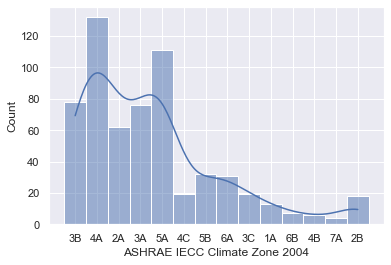

In [100]:
sns.histplot(nrel_filtered_df['ASHRAE IECC Climate Zone 2004'], kde=True)

In [116]:
geolocator = Nominatim(user_agent="ml-for-energy")
lats = []
longs = []
cities = []
cities_to_drop = []
for i, city in enumerate(nrel_filtered_df['City'].unique()):
    # print(city)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1,   return_value_on_exception = None)
    loc = geocode(city)
    # print(loc.raw)
    try:
        lats.append(loc.raw['lat'])
        longs.append(loc.raw['lon'])
        cities.append(city)
    except:
        print(city)
        cities_to_drop.append(city)


IN, Indianapolis City Balance
TN, Nashville-Davidson Metropolitan Government Balance
KY, Louisville Jefferson County Metro Government Balance
GA, Athens-Clarke County Unified Government Balance
GA, Augusta-Richmond County Consolidated Government Balance


In [94]:
# Drop rows with "Balance"
# nrel_out_df = nrel_out_df.drop(nrel_out_df[nrel_out_df['City'].str.contains("Balance")].index)

In [127]:
print(len(lats))

392


In [133]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 1800,
    'width': 1800,
    # 'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig = px.scatter_geo(lat=lats, lon=longs, scope='usa')
fig.show(config=config)

In [137]:
cities_db = pd.DataFrame()
cities_db['latitude'] = lats
cities_db['longitude'] = longs
cities_db['city'] = cities
cities_db.to_csv("cities.csv")
cities_db.head()

,latitude,longitude,city
0,34.0536909,-118.242766,"CA, Los Angeles"
1,40.7127281,-74.0060152,"NY, New York"
2,26.6091509,-81.652407,"FL, Lehigh Acres"
3,37.7385507,-121.4201395,"CA, Tracy"
4,38.6280278,-90.1910154,"MO, St Louis"


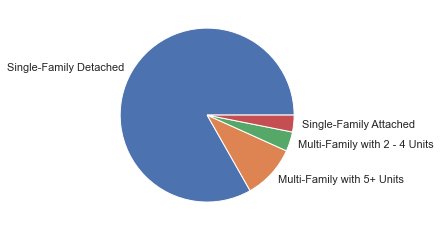

In [101]:
c = nrel_filtered_df['Geometry Building Type RECS'].value_counts()
plt.pie(c, labels = c.index)
plt.show()

<AxesSubplot: xlabel='Vintage', ylabel='Count'>

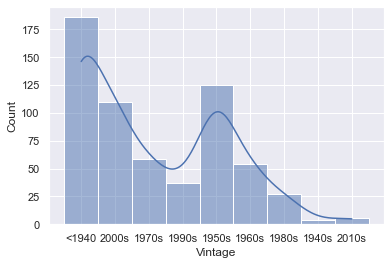

In [102]:
sns.histplot(nrel_filtered_df['Vintage'], kde=True)

From the NREL metadata: https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2022%2Fresstock_tmy3_release_1%2Fmetadata_and_annual_results%2Fnational%2Fcsv%2F

In [144]:
df = nrel_out_df.iloc[nrel_filtered_df.index.to_list()]
df.to_csv("resstock_filtered.csv")
nrel_filtered_df.to_csv("resstock_filtered_cleancols.csv")

In [3]:
baseline_metadata_only = pd.read_csv('baseline_metadata_only.csv')
baseline_metadata_only.head()

C:\Users\zoele\AppData\Local\Temp\ipykernel_55860\4285647504.py:1: DtypeWarning: Columns (61,121) have mixed types. Specify dtype option on import or set low_memory=False.
  baseline_metadata_only = pd.read_csv('baseline_metadata_only.csv')


,bldg_id,upgrade,weight,applicability,in.sqft,in.ahs_region,in.ashrae_iecc_climate_zone_2004,in.ashrae_iecc_climate_zone_2004_2_a_split,in.bathroom_spot_vent_hour,in.bedrooms,...,in.vintage,in.vintage_acs,in.water_heater_efficiency,in.water_heater_fuel,in.water_heater_in_unit,in.weather_file_city,in.weather_file_latitude,in.weather_file_longitude,in.window_areas,in.windows
0,1,0,242.131013,True,1690.0,Non-CBSA South Atlantic,4A,4A,Hour22,3,...,2000s,2000-09,Electric Standard,Electricity,Yes,Shannon Arpt,38.27,-77.45,F18 B18 L18 R18,"Double, Low-E, Non-metal, Air, M-Gain"
1,2,0,242.131013,True,1690.0,Non-CBSA Mountain,6B,6B,Hour22,3,...,1950s,1940-59,Natural Gas Standard,Natural Gas,Yes,Casper Natrona Co Intl Ap,42.90,-106.47,F12 B12 L12 R12,"Single, Clear, Non-metal"
2,4,0,242.131013,True,2176.0,Non-CBSA West South Central,2A,"2A - TX, LA",Hour7,4,...,1970s,1960-79,Electric Standard,Electricity,Yes,Lake Charles Wb Airp,30.22,-93.17,F12 B12 L12 R12,"Single, Clear, Metal"
3,5,0,242.131013,True,2176.0,Non-CBSA West North Central,4A,4A,Hour19,3,...,2000s,2000-09,Natural Gas Standard,Natural Gas,Yes,Fort Leonard Wood-Waynesville-St Robert Rgnl A...,37.75,-92.15,F9 B9 L9 R9,"Double, Low-E, Non-metal, Air, M-Gain"
4,6,0,242.131013,True,1690.0,"CBSA Miami-Fort Lauderdale-West Palm Beach, FL",2A,"2A - FL, GA, AL, MS",Hour7,3,...,1960s,1960-79,Electric Standard,Electricity,Yes,West Palm Beach Intl Arpt,26.68,-80.10,F12 B12 L12 R12,"Single, Clear, Non-metal"


## Conversion to numerical

In [4]:
resstock_filtered = pd.read_csv("resstock_filtered.csv", index_col=0)
resstock_filtered.head()

,Building,Schedules,Usage Level,Orientation,Eaves,Door Area,Overhangs,Interior Shading,Doors,Hot Water Fixtures,...,Federal Poverty Level,Window Areas,Insulation Ceiling,Insulation Roof,Insulation Wall,HVAC Cooling Partial Space Conditioning,Infiltration,REEDS Balancing Area,Generation And Emissions Assessment Region,City
0,1,Stochastic,Medium,West,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,0-100%,F15 B15 L15 R15,None,"Finished, R-13","Wood Stud, Uninsulated",100% Conditioned,15 ACH50,10,CAMXc,"CA, Los Angeles"
2,3,Stochastic,Medium,North,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,400%+,F12 B12 L12 R12,None,"Finished, R-30","Wood Stud, Uninsulated",60% Conditioned,25 ACH50,127,NYSTc,"NY, New York"
3,4,Stochastic,Medium,West,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,300-400%,F9 B9 L9 R9,R-30,"Unfinished, Uninsulated","Brick, 12-in, 3-wythe, R-15",100% Conditioned,10 ACH50,101,FRCCc,"FL, Lehigh Acres"
4,5,Stochastic,Medium,Southeast,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,100% Usage,...,400%+,F12 B12 L12 R12,R-30,"Unfinished, Uninsulated","Wood Stud, R-19",100% Conditioned,7 ACH50,9,CAMXc,"CA, Tracy"
9,10,Stochastic,Low,South,2 ft,20 ft^2,None,"Summer = 0.7, Winter = 0.85",Fiberglass,50% Usage,...,0-100%,F18 B18 L18 R18,R-7,"Unfinished, Uninsulated","Wood Stud, Uninsulated",100% Conditioned,10 ACH50,72,SRMWc,"MO, St Louis"


Information needed to build the shoebox:
- archetype *
- age *
- location (epw) *
- window construction (name of construction) *
- conditioning
    - heating/cooling schedule
    - mechanical ventilation schedule
    - heating/cooling fuel type *
    - heat recovery
    - economizer
    - heat recovery efficiency
    - heating/cooling COP *
    - heating/cooling setpoint *
- ventilation
    - infiltration *
- construction
    - construction types (materials & thicknesses) 
- domestic hot water
    - water supply temperature
    - water temperature inlet
    - flow rate per floor area *
    - hot water schedule
- internal mass
    - coverage area percentage
    - construction type
- internal loads
    - people density *
    - EPD *
    - LPD *
    - dimming
    - occupancy schedule
    - lighting schedule
    - equipment schedule

In [5]:
cz = resstock_filtered['ASHRAE IECC Climate Zone 2004'].unique()

array(['3B', '4A', '2A', '3A', '5A', '4C', '5B', '6A', '3C', '1A', '6B',
       '4B', '7A', '2B'], dtype=object)

In [30]:
resstock_filtered.filter(regex='Slab|Floor')

,Insulation Slab,Insulation Floor,Geometry Floor Area,Geometry Floor Area Bin
0,Uninsulated,None,500-749,0-1499
2,None,Uninsulated,1000-1499,0-1499
3,"2ft R5 Perimeter, Vertical",None,1500-1999,1500-2499
4,"2ft R5 Perimeter, Vertical",None,3000-3999,2500-3999
9,None,Uninsulated,1000-1499,0-1499
...,...,...,...,...
993,Uninsulated,None,1500-1999,1500-2499
994,None,Uninsulated,2500-2999,2500-3999
995,Uninsulated,None,1500-1999,1500-2499
996,Uninsulated,None,3000-3999,2500-3999


<AxesSubplot: ylabel='Count'>

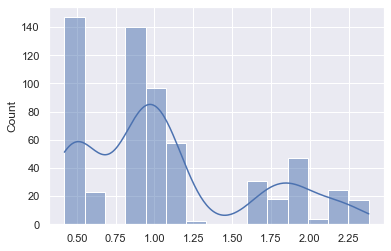

In [146]:
sns.histplot(plg_div*plg_loads, kde=True)

<AxesSubplot: xlabel='Plug Loads', ylabel='Count'>

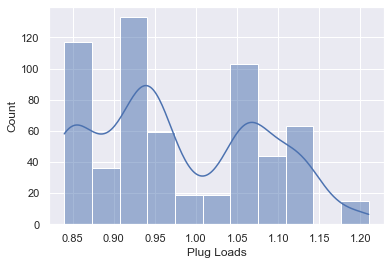

In [144]:
sns.histplot(plg_loads, kde=True)